<a href="https://colab.research.google.com/github/zhus-dika/DL_home_works/blob/main/shw_02_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

100%|██████████| 170498071/170498071 [00:12<00:00, 13124357.77it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

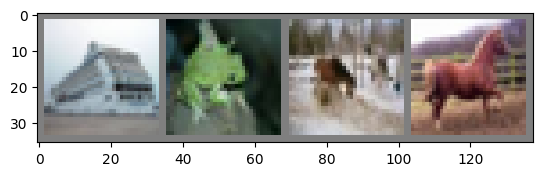

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
                    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1),
                    )
        self.conv2 = nn.Sequential(
                    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                    nn.BatchNorm2d(32)
                    )
        self.relu = nn.ReLU()
        self.avgpool = nn.AvgPool2d(8)
        self.classifier = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        out = self.relu(self.conv1(x) + self.conv2(x))
        out = self.avgpool(out)
        out = torch.flatten(out, start_dim=1)  # (B, 512)
        out = self.classifier(out)
        return out


In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
  (avgpool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (classifier): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [11]:
criterion = nn.CrossEntropyLoss().to(device)
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        logits = model(data)
        loss = criterion(logits, target)
        loss_log.append(loss.item() * data.shape[0])
        acc = (logits.argmax(dim=1) == target).sum()

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = nn.CrossEntropyLoss().to(device)
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item() * data.shape[0])
        acc = (logits.argmax(dim=1) == target).sum()
        acc_log.append(acc.item())
    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [12]:
criterion = nn.CrossEntropyLoss().to(device)
def test(model, loader):
    model.eval()
    loss_log, acc_log = 0.0, 0.0

    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        logits = model(data)
        loss = criterion(logits, target)
        loss_log += loss.item() * data.shape[0]
        acc_log += (logits.argmax(dim=1) == target).sum().item()
    return loss_log / len(loader.dataset), acc_log / len(loader.dataset)
def train(model, optimizer, num_epochs, train_loader, val_loader, scheduler=None):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = 0.0, 0.0
        model.train()
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            logits = model(data)
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.shape[0]
            train_accuracy += (logits.argmax(dim=1) == target).sum().item()

        if scheduler is not None:
            scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_accuracy /= len(train_loader.dataset)
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]

        test_loss, test_accuracy = 0.0, 0.0
        model.eval()
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            with torch.no_grad():
                logits = model(data)
                loss = criterion(logits, target)

            test_loss += loss.item() * data.shape[0]
            test_accuracy += (logits.argmax(dim=1) == target).sum().item()

        test_loss /= len(test_loader.dataset)
        test_accuracy /= len(test_loader.dataset)
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_accuracy)}")
        print(f" val loss: {test_loss}, val acc: {test_accuracy}\n")
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)
    return train_losses, train_accuracies, test_losses, test_accuracies

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

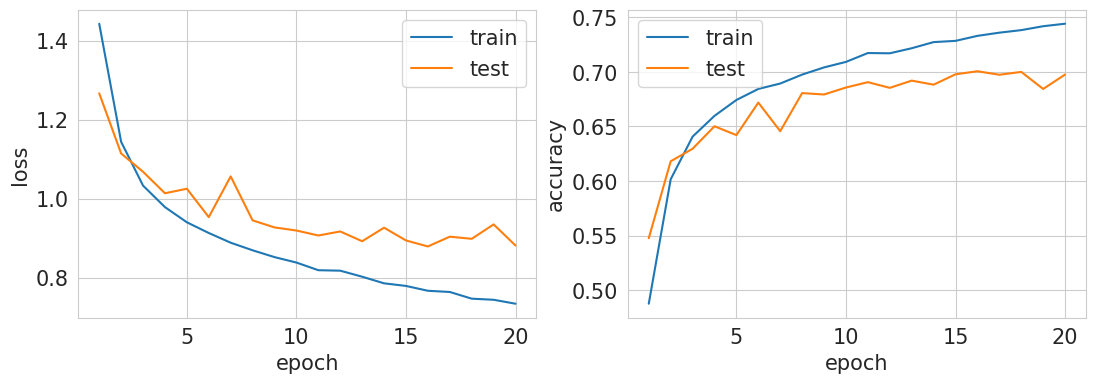

In [13]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Посчитайте точность на тестовой выборке:

In [14]:
test(net, val_loader)

(0.8619301918029785, 0.7037333333333333)

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

🐩 Выше построены 2 графика

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

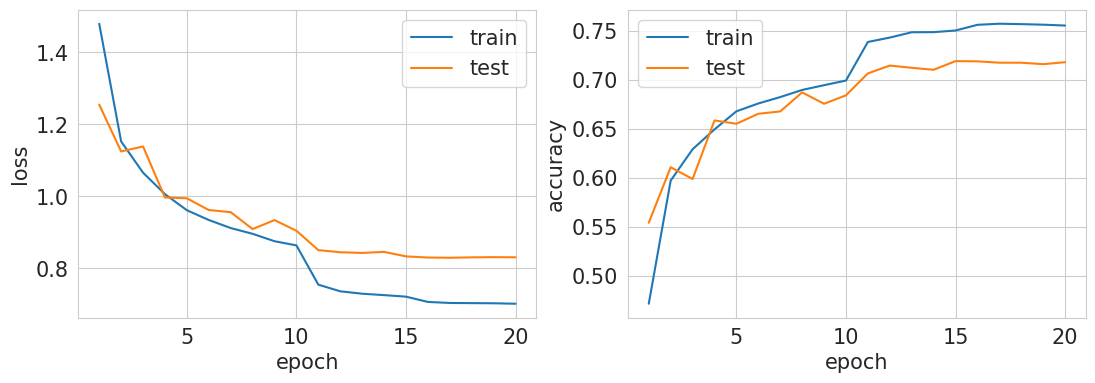

In [16]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Посчитайте точность на тестовой выборке:

In [17]:
test(net, val_loader)

(0.8053375133196513, 0.7214666666666667)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

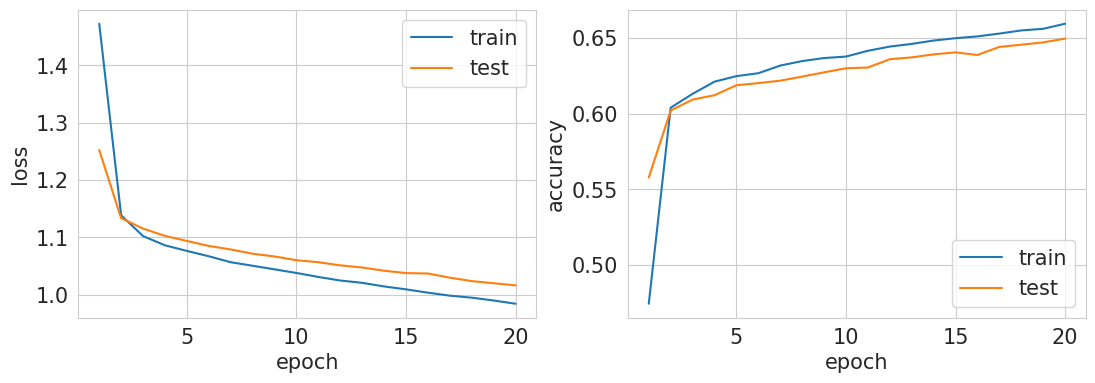

In [18]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1, 21], gamma=0.01)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

In [19]:
test(net, val_loader)

(1.0027007742563883, 0.6531333333333333)

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

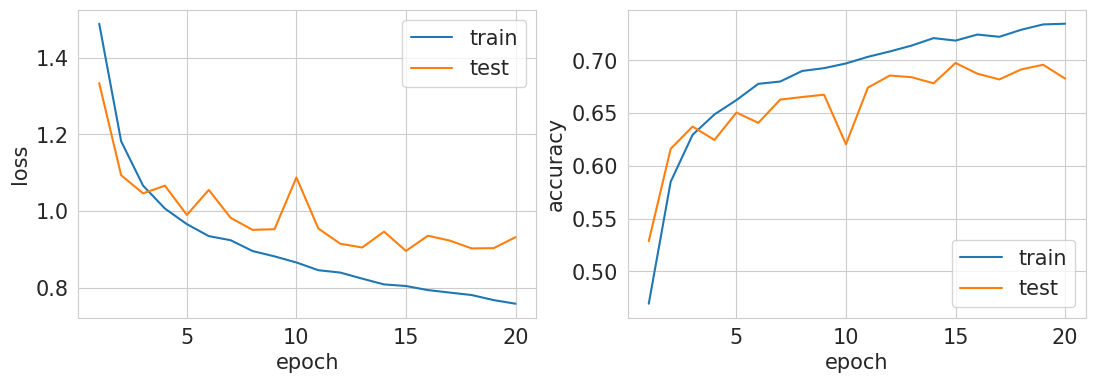

In [20]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 200)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

In [21]:
test(net, val_loader)

(0.8934842215220133, 0.6962666666666667)

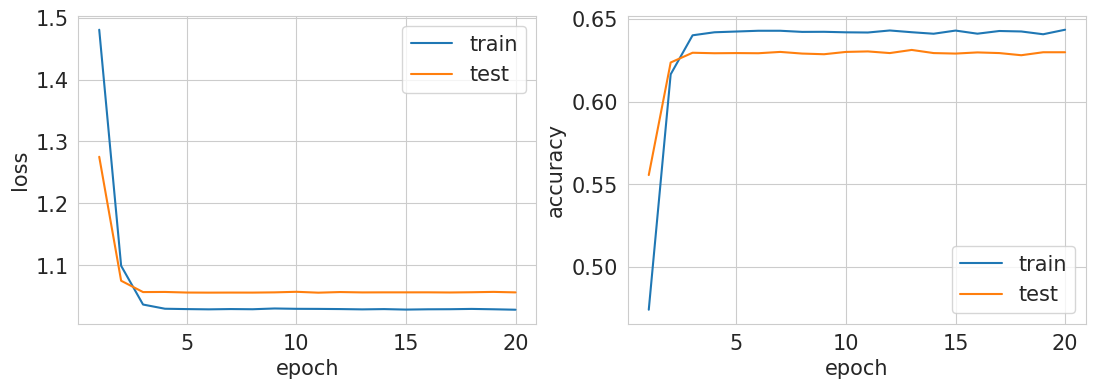

In [22]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

In [23]:
test(net, val_loader)

(1.0513877066612243, 0.6338666666666667)

Поработала с несколькими планировщиками, такими как

1. 🐫 torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0, last_epoch=- 1, verbose=False)

Установливается скорость обучения каждой группы параметров, при этом используется график косинусного уменьшения, начальное значение установлено на начальный lr и количество эпох на текущий момент устанаваливается c момента последнего перезапуска SGDR.

*Довольно хорошо учится.*
Результаты для теста (0.8630479038556417, 0.7032)
2.   🐑 torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=- 1, verbose=False)

Снижает скорость обучения каждой группы параметров по гамме каждую эпоху. Когда last_epoch=-1, устанавливает начальный lr как lr.

*Вообще не учится.*
Результаты для теста (1.0353832965532939, 0.6419333333333334)


## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

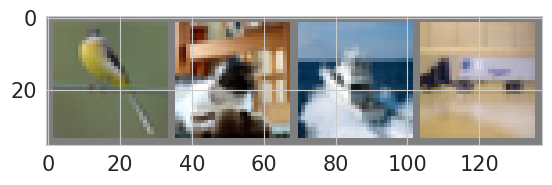

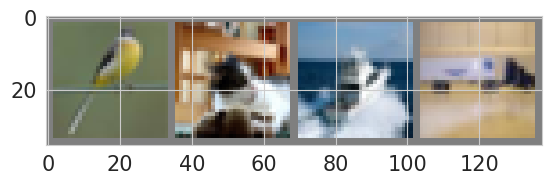

In [24]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

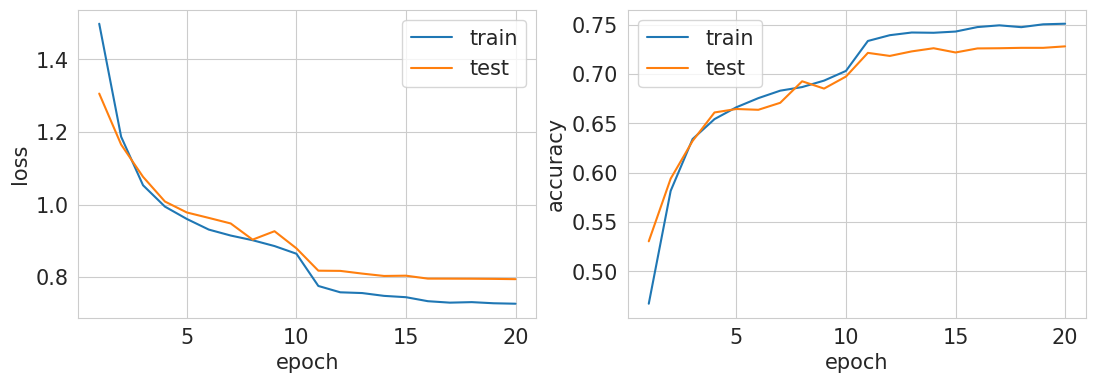

In [25]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Посчитайте точность на тестовой выборке:

In [26]:
test(net, val_loader)

(0.7829171654701232, 0.7293333333333333)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

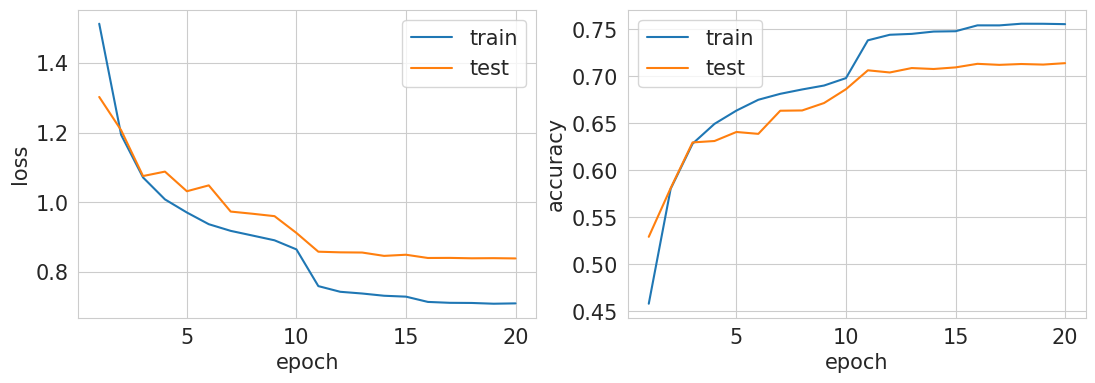

In [27]:
transform = transforms.Compose(
        [transforms.RandomCrop(size=(32, 32)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

In [28]:
test(net, val_loader)

(0.8262087805747986, 0.7175333333333334)

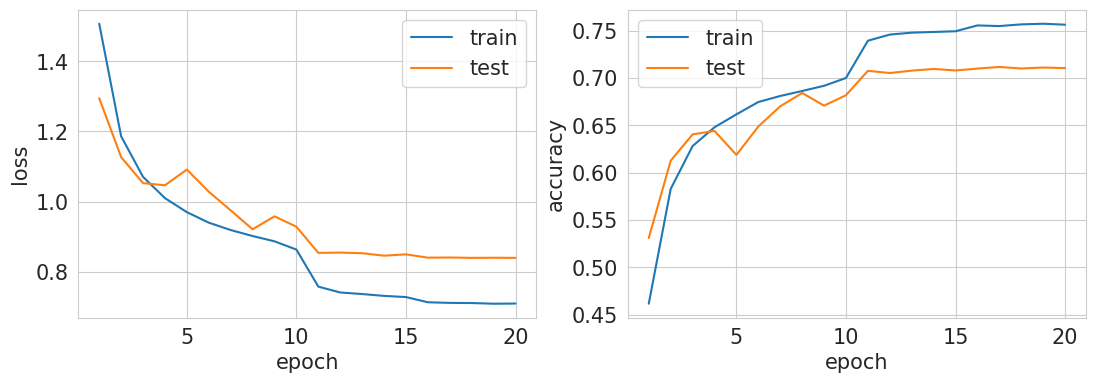

In [29]:
transform = transforms.Compose(
        [transforms.Resize(size=(32, 32)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

In [30]:
test(net, val_loader)

(0.8204064860026041, 0.7202666666666667)

1.   🦫 torchvision.transforms.RandomCrop(size, padding=None, pad_if_needed=False, fill=0, padding_mode='constant')

Обрезает изображение в случайном месте. Если изображение представляет собой тензор, ожидается, что оно будет иметь форму […, H, W], где … означает произвольное число начальных размеров, но если используется непостоянное заполнение, ожидается, что входные данные будут иметь не более 2 начальных размеров.

Довольно хорошо учится. Результаты для теста (0.811465819644928, 0.7224666666666667)
2.  🦙 T.Resize(size=size)

Изменяет размер входного изображения до заданного размера. Если изображение представляет собой тензор, ожидается, что оно будет иметь форму […, H, W], где … означает произвольное количество начальных измерений.

Тоже хорошо учится. Результаты для теста (0.8159057187398274, 0.7214666666666667)

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
!pip install wandb

In [46]:
!wandb login --relogin
#!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [47]:
import wandb

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()

    for i, (images, labels) in enumerate(tqdm(train_loader, desc=tqdm_desc), 1):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        accuracy = (logits.argmax(dim=1) == labels).sum().item()
        train_accuracy += accuracy

        if i % 10 == 0:
            wandb.log({'batch loss': loss.item(), 'batch accuracy': accuracy})

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs, name):
    wandb.init(project='Cifar10', name=name)
    wandb.watch(model)

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        wandb.log({
            "epoch": epoch, "train loss": train_loss, "train accuracy": train_accuracy,
            "test loss": test_loss, "test accuracy": test_accuracy,
            "lr": scheduler.get_last_lr()[0] if scheduler is not None else optimizer.param_groups[-1]['lr']
        })

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    wandb.finish()
    return train_losses, test_losses, train_accuracies, test_accuracies

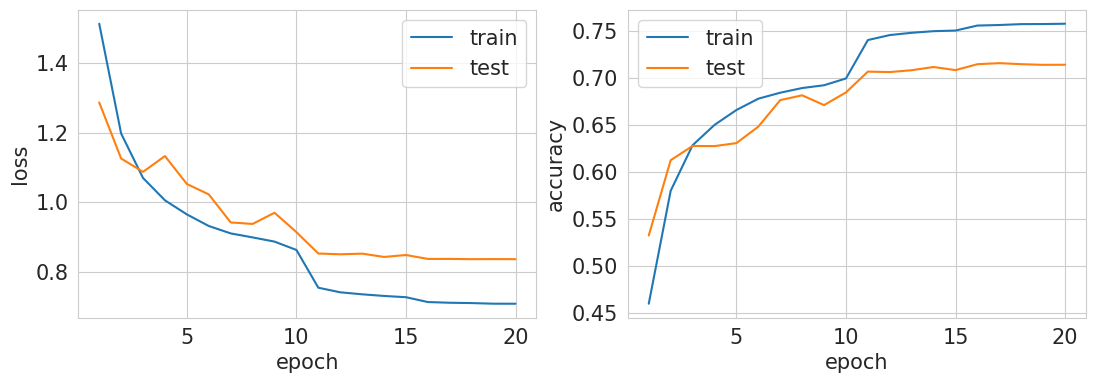

batch accuracy,▁▁▃▅▆▂▄▆▅▆▆▆▄▆▆▅▅▆▅▅▇▆▆▆▆▆▇▇▆▇▆▆▇▆▅▅█▇▆█
batch loss,▇█▆▄▄▆▄▄▄▃▃▃▅▃▃▃▄▃▃▃▂▃▂▂▃▂▂▂▂▂▃▃▂▂▃▂▁▁▄▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
lr,██████████▂▂▂▂▂▁▁▁▁▁
test accuracy,▁▄▅▅▅▅▆▇▆▇██████████
test loss,█▅▅▆▄▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁
train accuracy,▁▄▅▅▆▆▆▆▆▇██████████
train loss,█▅▄▄▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁
batch accuracy,51
batch loss,0.55813
epoch,20


In [48]:
train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
criterion = nn.CrossEntropyLoss().to(device)
train_losses, test_losses, train_accuracies, test_accuracies = train(
    net, optimizer, scheduler, criterion, train_loader, test_loader,
    20, name='Basic Block from ResNet'
)

🐘 Cсылка на проект  https://wandb.ai/zhus_dika/Cifar10/